<AxesSubplot:xlabel='Date'>

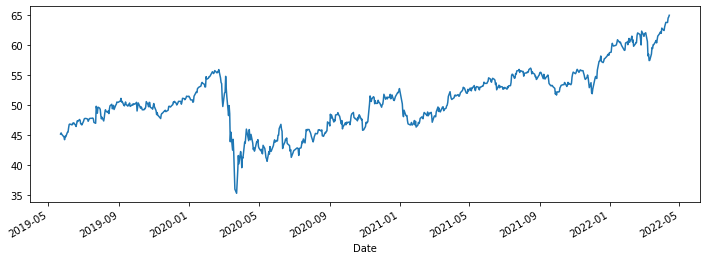

In [1]:
#!pip install yfinance
import yfinance as yf
tickerS = "KO"
tickerData = yf.Ticker(tickerS)
tickerDf = tickerData.history(start = '2019-05-23', end = '2022-04-17', interval="1d", actions=False)
tickerDf.Close.plot(figsize=(12, 4))

In [2]:
def traiding(high_train, low_train, high_test, low_test, close, l):
    all_profit = 0
    profit = 0
    pos = False
    num_steps = len(close)
    deals = []
    comission = 0.04
    for step in range(num_steps):
        buy_price = low_train[step]*l
        sell_price = high_train[step]*l
        if buy_price >= low_test[step]:
            pos = True
            profit -= comission /100 * buy_price
        if pos:
            if sell_price <= high_test[step]:
                p = sell_price-buy_price
                status = 'succes'
                #print("_________________________________________________________")
            else:
                sell_price = close[step]
                p = sell_price*(1-comission/100)-buy_price
                if p<=0:
                    status = 'failed'
                else:
                    status = 'ыбыбыб'
            profit += p
            pos = False
            deals.append({'status' : status, 'buy_price' : buy_price, 'sell_price' : sell_price, 'profit' : p})
    return deals

In [3]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

def regressor(high, prediction_columns):
    x = high[prediction_columns[1:]]#.values
    y = high[prediction_columns[0]]#.values.reshape(-1,1)
    high_x_train, high_x_test, high_train, high_test = train_test_split(x, y, test_size=0.33, random_state = 42, shuffle = False)
    catboost_high = CatBoostRegressor(iterations=500,
                                   learning_rate=0.03,
                                   depth=8,
                                   l2_leaf_reg=7,
                                   loss_function='MAE')
    catboost_high.fit(high_x_train, high_train)
    return catboost_high, high_x_test, high_test

def inversion(a, high_min, lambda_high, high1):
    #inv_high_test_from_minmax_to_diff = inv_minmax(a.reshape(-1,1), high_min)
    #inv_high_test_from_diff_to_boxcox = inv_diff(high1, inv_high_test_from_minmax_to_diff.reshape(-1))
    #inv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox.reshape(-1), lambda_high)
    inv_high_test = inv_diff(high1, a.reshape(-1))
    return inv_high_test

def boxcoxMy(data, columnOld, columnNew):
    trans, lambda_ = boxcox(data[columnOld].values)
    data[columnNew] = trans
    return lambda_

def inv_boxcoxMyforLag(data, lambda_, columnOld, columnNew):
    #data[columnNew] = inv_boxcox(data[columnOld].values, lambda_)
    #data[columnNew].plot()
    data[columnOld] = inv_boxcox(data[columnOld].values, lambda_)
    
def inv_box_cox(data, lambda_):
    return inv_boxcox(data, lambda_)
    
def diff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].diff()
    #data[columnNew].plot()
    
def inv_diff(high1, high_test):
    return high1[len(high1) - len(high_test)-1:-1]+high_test

def anotherDiff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].pct_change()
    #data[columnNew].plot()

def minmax(data, columnOld, columnNew):
    scaler = MinMaxScaler()
    data[columnNew] = scaler.fit_transform(data[columnOld].values.reshape(-1,1))
    #data[columnNew].plot()
    return scaler.fit(data[columnOld].values.reshape(-1,1))

def inv_minmax(data, obj):
    #scaler = MinMaxScaler()
    #scaler = scaler.fit(data[columnOld].values.reshape(-1,1))
    #data[columnNew] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    #data[columnOld] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    return obj.inverse_transform(data).reshape(-1,1)
    
def lag_fich(data, prediction_columns):
    for i in range(1, prediction_window+1):
        col_name = f'shift_{i}'
        prediction_columns.append(col_name)
        data[col_name] = data[prediction_columns[0]].shift(i)
    #data.plot()
    return data[prediction_columns].dropna()

def metrics(inv_high_x, inv_high_test):
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error', mean_squared_error(inv_high_x,inv_high_test))

    from sklearn.metrics import mean_absolute_error
    print('mean_absolute_error',mean_absolute_error(inv_high_test, inv_high_x))

    from sklearn.metrics import mean_absolute_percentage_error
    print('mean_absolute_percentage_error',mean_absolute_percentage_error(inv_high_test, inv_high_x))

In [4]:
lag = 10

#tickerDf = tickerDf.reset_index()

low = tickerDf.copy()
high = tickerDf.copy()
close = tickerDf.copy()

#lambda_high = boxcoxMy(high, 'High', 'boxcox')
#lambda_low = boxcoxMy(low, 'Low', 'boxcox')
#lambda_close =boxcoxMy(close, 'Close', 'boxcox')
high1 = high['High'].values[lag:].copy()
#low1 = low['Low'].values[lag:].copy()

#diff(high, 'High', 'diff')
#diff(low, 'Low', 'diff')
#diff(close, 'boxcox', 'diff')
#anotherDiff(close, 'Close', 'anotherDiff')
#high_min = minmax(high, 'diff', 'minmax_scaler')
#low_min = minmax(low, 'diff', 'minmax_scaler')
#minmax(close, 'boxcox', 'minmax_scaler')

In [5]:
prediction_window = lag
prediction_columns = ['Close']
close = lag_fich(close, prediction_columns)

prediction_window = lag
prediction_columns = ['High']
high = lag_fich(high, prediction_columns)

In [6]:
regressor_high, high_x_test, high_test = regressor(high, prediction_columns)

0:	learn: 2.5383958	total: 157ms	remaining: 1m 18s
1:	learn: 2.4725083	total: 164ms	remaining: 40.9s
2:	learn: 2.4096853	total: 172ms	remaining: 28.4s
3:	learn: 2.3448646	total: 179ms	remaining: 22.1s
4:	learn: 2.2802934	total: 185ms	remaining: 18.3s
5:	learn: 2.2192890	total: 192ms	remaining: 15.8s
6:	learn: 2.1608117	total: 199ms	remaining: 14s
7:	learn: 2.1029414	total: 206ms	remaining: 12.7s
8:	learn: 2.0493223	total: 212ms	remaining: 11.6s
9:	learn: 1.9961454	total: 218ms	remaining: 10.7s
10:	learn: 1.9482970	total: 224ms	remaining: 9.95s
11:	learn: 1.8979637	total: 231ms	remaining: 9.38s
12:	learn: 1.8463806	total: 238ms	remaining: 8.92s
13:	learn: 1.7993238	total: 250ms	remaining: 8.67s
14:	learn: 1.7493015	total: 257ms	remaining: 8.3s
15:	learn: 1.7059957	total: 267ms	remaining: 8.08s
16:	learn: 1.6630390	total: 274ms	remaining: 7.79s
17:	learn: 1.6224052	total: 282ms	remaining: 7.56s
18:	learn: 1.5805543	total: 289ms	remaining: 7.32s
19:	learn: 1.5409763	total: 299ms	remaining

163:	learn: 0.3770468	total: 1.47s	remaining: 3.01s
164:	learn: 0.3755661	total: 1.48s	remaining: 3s
165:	learn: 0.3746215	total: 1.49s	remaining: 2.99s
166:	learn: 0.3736271	total: 1.49s	remaining: 2.98s
167:	learn: 0.3727588	total: 1.5s	remaining: 2.97s
168:	learn: 0.3719042	total: 1.51s	remaining: 2.96s
169:	learn: 0.3709900	total: 1.52s	remaining: 2.94s
170:	learn: 0.3700822	total: 1.52s	remaining: 2.93s
171:	learn: 0.3692270	total: 1.53s	remaining: 2.92s
172:	learn: 0.3683514	total: 1.54s	remaining: 2.9s
173:	learn: 0.3676267	total: 1.54s	remaining: 2.89s
174:	learn: 0.3669331	total: 1.55s	remaining: 2.88s
175:	learn: 0.3659254	total: 1.56s	remaining: 2.87s
176:	learn: 0.3649166	total: 1.56s	remaining: 2.85s
177:	learn: 0.3636670	total: 1.57s	remaining: 2.84s
178:	learn: 0.3625148	total: 1.58s	remaining: 2.83s
179:	learn: 0.3618098	total: 1.58s	remaining: 2.82s
180:	learn: 0.3613390	total: 1.59s	remaining: 2.81s
181:	learn: 0.3609090	total: 1.6s	remaining: 2.79s
182:	learn: 0.3600

344:	learn: 0.2407950	total: 2.74s	remaining: 1.23s
345:	learn: 0.2404199	total: 2.75s	remaining: 1.22s
346:	learn: 0.2397591	total: 2.75s	remaining: 1.21s
347:	learn: 0.2396179	total: 2.76s	remaining: 1.2s
348:	learn: 0.2387319	total: 2.76s	remaining: 1.2s
349:	learn: 0.2380464	total: 2.77s	remaining: 1.19s
350:	learn: 0.2371898	total: 2.78s	remaining: 1.18s
351:	learn: 0.2367482	total: 2.78s	remaining: 1.17s
352:	learn: 0.2359466	total: 2.79s	remaining: 1.16s
353:	learn: 0.2351675	total: 2.79s	remaining: 1.15s
354:	learn: 0.2349990	total: 2.8s	remaining: 1.14s
355:	learn: 0.2342871	total: 2.81s	remaining: 1.14s
356:	learn: 0.2337427	total: 2.81s	remaining: 1.13s
357:	learn: 0.2330217	total: 2.82s	remaining: 1.12s
358:	learn: 0.2325916	total: 2.83s	remaining: 1.11s
359:	learn: 0.2319789	total: 2.83s	remaining: 1.1s
360:	learn: 0.2315344	total: 2.84s	remaining: 1.09s
361:	learn: 0.2308421	total: 2.84s	remaining: 1.08s
362:	learn: 0.2302743	total: 2.85s	remaining: 1.07s
363:	learn: 0.22

In [7]:
prediction_window = lag
prediction_columns = ['Low']
low = lag_fich(low, prediction_columns)

<AxesSubplot:>

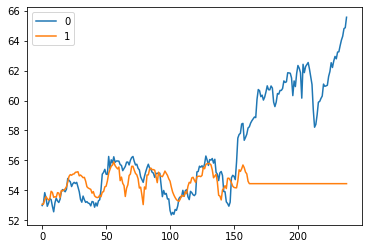

In [8]:
import pandas as pd
df = pd.DataFrame([high_test.values, regressor_high.predict(high_x_test)]).T
df.plot()

In [9]:
#inv_high_test = inversion(high_test.values, high_min, lambda_high, high1)
#inv_high_x = inversion(regressor_high.predict(high_x_test), high_min, lambda_high, high1)

#inv_high_test = inversion(high_test.values, high1, high1, high1)
#inv_high_x = inversion(regressor_high.predict(high_x_test), high1, high1, high1)

inv_high_test = high_test.values
inv_high_x = regressor_high.predict(high_x_test)

<AxesSubplot:xlabel='Date', ylabel='Price $'>

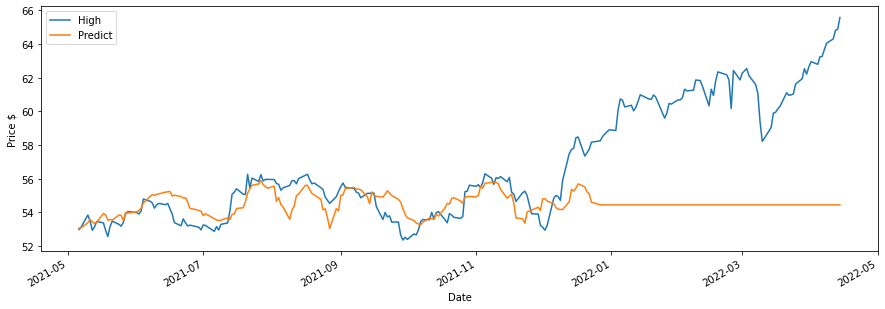

In [10]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[:].plot(ylabel='Price $',figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Price $'>

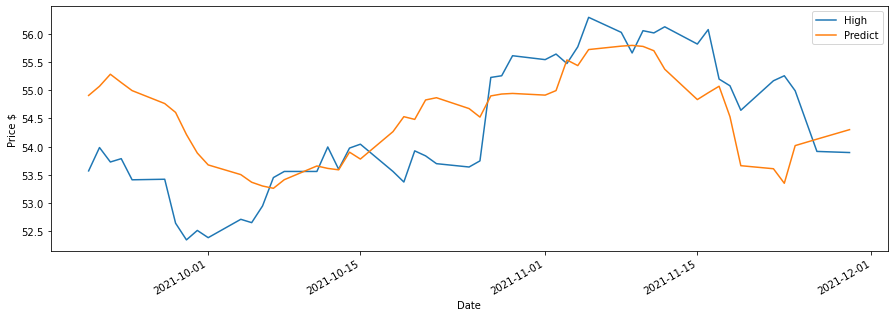

In [11]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[-len(inv_high_x)//2-25:-len(inv_high_x)//2+25].plot(ylabel='Price $',figsize=(15,5))

In [12]:
metrics(inv_high_x, inv_high_test)

mean_squared_error 16.088091995955367
mean_absolute_error 2.724253296757121
mean_absolute_percentage_error 0.04539870921053107


In [13]:
regressor_low, low_x_test, low_test = regressor(low, prediction_columns)

0:	learn: 2.6758869	total: 15.2ms	remaining: 7.61s
1:	learn: 2.6070878	total: 28.7ms	remaining: 7.13s
2:	learn: 2.5373128	total: 42.9ms	remaining: 7.11s
3:	learn: 2.4691208	total: 57.9ms	remaining: 7.17s
4:	learn: 2.4050036	total: 72.9ms	remaining: 7.22s
5:	learn: 2.3411396	total: 85ms	remaining: 7s
6:	learn: 2.2762750	total: 98.2ms	remaining: 6.92s
7:	learn: 2.2145320	total: 114ms	remaining: 6.99s
8:	learn: 2.1580997	total: 127ms	remaining: 6.95s
9:	learn: 2.1011281	total: 141ms	remaining: 6.91s
10:	learn: 2.0503027	total: 155ms	remaining: 6.88s
11:	learn: 1.9954800	total: 172ms	remaining: 7.01s
12:	learn: 1.9439854	total: 186ms	remaining: 6.96s
13:	learn: 1.8933034	total: 201ms	remaining: 6.97s
14:	learn: 1.8448057	total: 218ms	remaining: 7.05s
15:	learn: 1.7998426	total: 233ms	remaining: 7.06s
16:	learn: 1.7545917	total: 248ms	remaining: 7.04s
17:	learn: 1.7117839	total: 261ms	remaining: 6.99s
18:	learn: 1.6682758	total: 273ms	remaining: 6.91s
19:	learn: 1.6288831	total: 286ms	remai

169:	learn: 0.4143903	total: 2.38s	remaining: 4.62s
170:	learn: 0.4135622	total: 2.4s	remaining: 4.61s
171:	learn: 0.4119272	total: 2.41s	remaining: 4.6s
172:	learn: 0.4106404	total: 2.43s	remaining: 4.59s
173:	learn: 0.4090880	total: 2.44s	remaining: 4.57s
174:	learn: 0.4079649	total: 2.46s	remaining: 4.56s
175:	learn: 0.4070813	total: 2.47s	remaining: 4.55s
176:	learn: 0.4059035	total: 2.49s	remaining: 4.54s
177:	learn: 0.4046843	total: 2.5s	remaining: 4.53s
178:	learn: 0.4036033	total: 2.52s	remaining: 4.52s
179:	learn: 0.4023947	total: 2.53s	remaining: 4.5s
180:	learn: 0.4012354	total: 2.55s	remaining: 4.49s
181:	learn: 0.4001565	total: 2.56s	remaining: 4.48s
182:	learn: 0.3991390	total: 2.58s	remaining: 4.46s
183:	learn: 0.3980206	total: 2.59s	remaining: 4.45s
184:	learn: 0.3973438	total: 2.6s	remaining: 4.43s
185:	learn: 0.3967181	total: 2.62s	remaining: 4.42s
186:	learn: 0.3957615	total: 2.63s	remaining: 4.4s
187:	learn: 0.3943532	total: 2.64s	remaining: 4.38s
188:	learn: 0.3928

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame([low_test.values, regressor_low.predict(low_x_test)]).T
df.plot()

In [ ]:
#inv_low_test = inversion(low_test.values, low_min, lambda_low, low1)
#inv_low_x = inversion(regressor_low.predict(low_x_test), low_min, lambda_low, low1)
#inv_low_test = inversion(low_test.values, low1, low1, low1)
#inv_low_x = inversion(regressor_low.predict(low_x_test), low1, low1, low1)

inv_low_test = low_test.values
inv_low_x = regressor_low.predict(low_x_test)

In [ ]:
metrics(inv_low_x, inv_low_test)

In [ ]:
df = pd.DataFrame([inv_low_test, inv_low_x]).T
df.plot(figsize=(15,5))

In [ ]:
l = 1
deals = traiding(inv_high_x, inv_low_x, inv_high_test, inv_low_test, close.Close.iloc[len(high1) - len(high_test):].values, l)
print('profit =', sum([i['profit'] for i in deals]))
deals

In [ ]:
print(f"{str(deals).count('succes')}/{len(deals)} successesful deals")